# Aerial Cactus Identification

This is my very first data science project. The task is to **classify aerial images of a protected area in Mexico to identify the presence of cactuses**, in order to estimate the total area covered with this species. Here is the project's official description:

>To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas. In this competition, you are tasked with creation of an algorithm that can identify a specific type of cactus in aerial imagery.

It project was part of my first deep learning course in April 2020 and was aimed for me to become familiar, on a simple binary classificatino task, with how neural networks work and how they are implemented. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import zipfile
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv


In [2]:
import torch
from torchvision import transforms, models
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from skimage import io
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split

## Data Importation and Formatting

In [3]:
data = pd.read_csv("../input/aerial-cactus-identification/train.csv", dtype=str)

In [4]:
zip_ref_data = zipfile.ZipFile("../input/aerial-cactus-identification/train.zip","r")
zip_ref_data.extractall()

In [5]:
zip_ref_test = zipfile.ZipFile("../input/aerial-cactus-identification/test.zip","r")
zip_ref_test.extractall()

In [6]:
data_csv_path = "../input/aerial-cactus-identification/train.csv"
data_path = "./train"

In [7]:
data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
#data formatting, normalization and augmentation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.3,0.3,0.3), (0.5,0.5,0.5)),
     transforms.RandomHorizontalFlip()
     #transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(1, 1.1)),
     #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0),
])

In [9]:
#create the dataset class
class CactusDataset(Dataset):
    """Dataset class for the cactus dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir 
        self.transform = transform
        self.labels = pd.read_csv(csv_file)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):

        img_path = os.path.join(self.root_dir, self.labels.iloc[idx, 0]) 
        image = Image.open(img_path)
        label = self.labels.has_cactus[idx]

        if self.transform:
            image = self.transform(image)

        return [image, label]
        

In [10]:
dataset = CactusDataset(data_csv_path, data_path, transform)
train_set, val_set = torch.utils.data.random_split(dataset, [15000, 2500], generator=torch.Generator().manual_seed(42)) #fix the generator for reproductibility

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

## Exploratory Data Analysis

In [11]:
len_dataset = len(data)
cactus, no_cactus = data.has_cactus.value_counts()
print(f'Dataset size: {len_dataset}')
print(f'Relative frequencies: {100*cactus/len_dataset}% cactus, {100*no_cactus/len_dataset}% no cactus.')

Dataset size: 17500
Relative frequencies: 75.06285714285714% cactus, 24.937142857142856% no cactus.


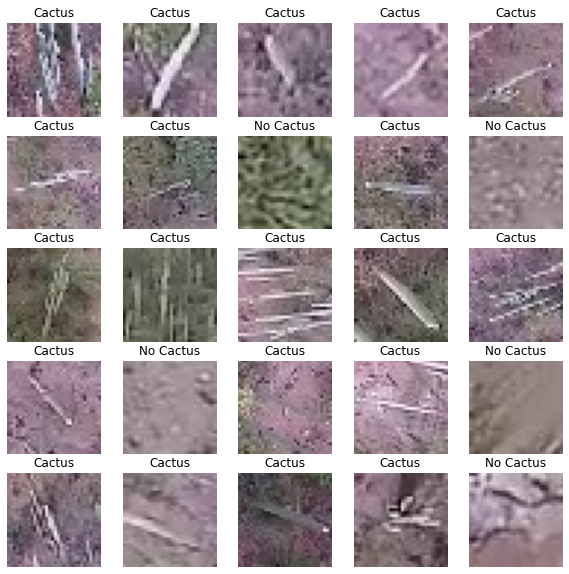

In [12]:
#sample vizualisation

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
indices = np.random.choice(list(range(len(train_set))),25)
for i, idx in enumerate(indices):
    img, label = train_set[idx]
    img = img*0.5 + 0.3 #unnormalize
    img = img.numpy().transpose(1, 2, 0)
    axes.flatten()[i].imshow(img)
    if label == 1:
        description = 'Cactus'
    else:
        description = 'No Cactus'
    
    axes.flatten()[i].set_title(description)
    axes.flatten()[i].set_axis_off()


## Model

In [14]:
#load the model
net = models.vgg16_bn(pretrained=True)
net.classifier[6] = nn.Linear(4096, 1)
net.classifier.add_module('7', nn.Sigmoid())

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()

using cuda


In [16]:
fine_tuning = True

if fine_tuning :
    for param in net.features.parameters():
        param.requires_grad = True

    '''optimizer = optim.SGD([
                {'params': net.features.parameters(), 'lr':1e-4},
                {'params': net.classifier.parameters(), 'lr': 1e-3}
                ], momentum=0.9)'''
    
    optimizer = optim.AdamW([
                {'params': net.features.parameters(), 'lr':1e-5},
                {'params': net.classifier.parameters(), 'lr': 1e-4}
                ])
  
else :
    for param in net.features.parameters():
        param.requires_grad = False
  
    optimizer = optim.AdamW(net.classifier.parameters(), lr=1e-3)
    

criterion = nn.BCELoss()

In [17]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Implementing Training Functions

In [18]:
def train(net, optimizer, train_loader, val_loader, criterion, 
          n_epoch=10,
          train_acc_period=100,
          val_acc_period=5,
          conf_matrix=False,
          cuda=True,
          verbose=False):
    
    #Tableaux de stats
    train_acc_values = []
    val_acc_values = []        
    train_loss_values = []
    val_loss_values = []
    
    false_positives = []
    true_positives = []
    false_negatives = []
    true_negatives = []
    
    if verbose: print('Calculating train set accuracy and loss... ')
    train_acc, train_loss = accuracy(net, train_loader, criterion, cuda=cuda)
        
    if verbose: print('Calculating validation set accuracy and loss... ')
    val_acc, val_loss = accuracy(net, val_loader, criterion, cuda=cuda)
            
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)    
    
    if verbose: 
        print('With validation set: ')
        print('[%d] loss: %.8f' %(0, val_loss))
        print('[%d] acc: %.8f' %(0, val_acc))
    
    for epoch in notebook.tqdm(range(n_epoch)):
        print('Epoch: ', epoch)
        total = 0
        for i, data in enumerate(train_loader, 0):
            
            net.train()
            inputs, labels = data
            labels = labels.type(torch.FloatTensor) 
            
            if cuda:
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.FloatTensor)
          
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = net(inputs)
            outputs = torch.squeeze(outputs) 
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            net.eval()
            cur_loss = loss.item()/labels.size(0)
            
            predicted = torch.round(outputs.data) 
            correct = (predicted == labels).sum().item()/labels.size(0)
            cur_acc = correct
            
            if verbose and i % train_acc_period == train_acc_period-1:
                print('[%d, %5d] loss: %.8f' %(epoch + 1, i + 1, cur_loss))
                print('[%d, %5d] acc: %.8f' %(epoch + 1, i + 1, cur_acc))
                cur_loss = 0.0
       
        #metrics
        if verbose: print('Calculating train set accuracy and loss... ')
        train_acc, train_loss = accuracy(net, train_loader, criterion, cuda=cuda)
        
        if verbose: print('Calculating validation set accuracy and loss... ')
        val_acc, val_loss = accuracy(net, val_loader, criterion, cuda=cuda)
            
        train_acc_values.append(train_acc)
        val_acc_values.append(val_acc)
        train_loss_values.append(train_loss)
        val_loss_values.append(val_loss)    
        
        if epoch % val_acc_period == val_acc_period-1:
            print('With validation set: ')
            print('[%d] loss: %.8f' %(epoch + 1, val_loss))
            print('[%d] acc: %.8f' %(epoch + 1, val_acc))
        
        if conf_matrix:
            FP, TP, TN, FN = confusion_matrix(net,val_set)
            false_positives.append(FP)
            true_positives.append(TP)
            false_negatives.append(FN)
            true_negatives.append(TN)
     
    print('Training completed!')
    
    return {'train_acc' : train_acc_values, 
            'val_acc' : val_acc_values , 
            'train_loss' : train_loss_values, 
            'val_loss' : val_loss_values,
            'FP': false_positives, 
            'TP': true_positives, 
            'FN': false_negatives, 
            'TN':true_negatives}

In [19]:
def accuracy(net, test_loader, criterion, cuda=True):
    net.eval()
    correct = 0
    total = 0
    loss = 0
    
    with torch.no_grad():
        for data in notebook.tqdm(test_loader):
            images, labels = data

            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.FloatTensor)
                
            outputs = net(images)
            outputs = torch.squeeze(outputs)
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss+= criterion(outputs, labels)
    
    net.train()
    #print('Accuracy of the network on the validation images: %d %%' % (
    #  100. * correct / total))

    return correct/total, loss/total

In [20]:
def confusion_matrix(net, test_loader, cuda=True):
    test_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)
    net.eval()
    false_positive = 0
    false_negative = 0
    true_positive = 0
    true_negative = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.FloatTensor)
                
            outputs = net(images)
            outputs = torch.squeeze(outputs)
            predicted = torch.round(outputs.data)
            
            total += labels.size(0)
            
            true_positive += (predicted == labels and labels == 1.).sum().item()
            true_negative += (predicted == labels and labels == 0.).sum().item()
            false_positive += (predicted == 1. and labels == 0.).sum().item()
            false_negative += (predicted == 0. and labels == 1.).sum().item()
    
    net.train()
    print('Confusion Matrix')
    print('true positives: ',true_positive/total)
    print('true negatives: ',true_negative/total)
    print('false positives:', false_positive/total)
    print('false negatives:', false_negative/total)

    return [true_positive, true_negative, false_positive, false_negative]

In [21]:
def roc(net, data_set):
    return confusion_matrix(net, data_set)[0], confusion_matrix(net,data_set)[1]

# Training

In [22]:
torch.cuda.is_available()

True

In [23]:
results = train(net, optimizer, train_loader, val_loader, criterion,  n_epoch = 15,
      train_acc_period=50,
      val_acc_period=5,
      conf_matrix=True,
      cuda=True)

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7424
true negatives:  0.2384
false positives: 0.0104
false negatives: 0.0088
Epoch:  1


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.744
true negatives:  0.2436
false positives: 0.0052
false negatives: 0.0072
Epoch:  2


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7472
true negatives:  0.2408
false positives: 0.008
false negatives: 0.004
Epoch:  3


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7464
true negatives:  0.2444
false positives: 0.0044
false negatives: 0.0048
Epoch:  4


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

With validation set: 
[5] loss: 0.00015219
[5] acc: 0.99280000
Confusion Matrix
true positives:  0.7472
true negatives:  0.2448
false positives: 0.004
false negatives: 0.004
Epoch:  5


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7508
true negatives:  0.24
false positives: 0.0088
false negatives: 0.0004
Epoch:  6


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.746
true negatives:  0.2468
false positives: 0.002
false negatives: 0.0052
Epoch:  7


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7436
true negatives:  0.2476
false positives: 0.0012
false negatives: 0.0076
Epoch:  8


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7496
true negatives:  0.2436
false positives: 0.0052
false negatives: 0.0016
Epoch:  9


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

With validation set: 
[10] loss: 0.00043493
[10] acc: 0.99440000
Confusion Matrix
true positives:  0.7492
true negatives:  0.2464
false positives: 0.0024
false negatives: 0.002
Epoch:  10


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7484
true negatives:  0.246
false positives: 0.0028
false negatives: 0.0028
Epoch:  11


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.744
true negatives:  0.248
false positives: 0.0008
false negatives: 0.0072
Epoch:  12


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7496
true negatives:  0.2452
false positives: 0.0036
false negatives: 0.0016
Epoch:  13


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Confusion Matrix
true positives:  0.7488
true negatives:  0.2456
false positives: 0.0032
false negatives: 0.0024
Epoch:  14


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

With validation set: 
[15] loss: 0.00014136
[15] acc: 0.99520000
Confusion Matrix
true positives:  0.7476
true negatives:  0.2476
false positives: 0.0012
false negatives: 0.0036
Training completed!


# Results visualization

In [24]:
def roc_curve(net, false_positive, true_positive, false_negative, true_negative):
    if (len(false_positive)!=len(true_negative)):
        print('Not the same size')
        return
    else :
        TVP=[]
        TFP=[]
        for i in range(len(false_positive)):
            sum1 = false_negative[i] + true_positive[i]
            TVP.append(true_positive[i]/sum1)
            sum2 = false_positive[i]+true_negative[i]
            TFP.append(false_positive[i]/sum2)
        TFP.sort()
        plt.plot(TFP,TVP)
        plt.xlabel('TFP')                      
        plt.ylabel('TVP')     
        plt.title ('ROC curve on the validation set')
        plt.fill_between(TFP,TVP,0,color='0.8')
        auc = np.trapz(np.array(TVP),np.array(TFP))
        plt.show()
    return TFP, TVP

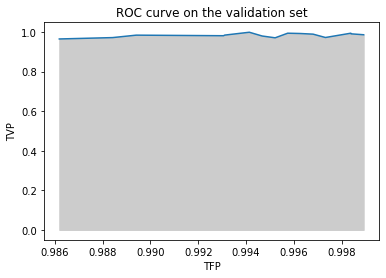

([0.9861849096705633,
  0.9884149552395998,
  0.989406779661017,
  0.993059263214095,
  0.9931107578166402,
  0.9941395844432606,
  0.9946751863684771,
  0.9952203929899097,
  0.9957446808510638,
  0.996272630457934,
  0.9968068121341139,
  0.9973262032085561,
  0.9983888292158969,
  0.9983974358974359,
  0.9989258861439313],
 [0.9644012944983819,
  0.9712918660287081,
  0.9836601307189542,
  0.9807383627608347,
  0.9839228295819936,
  0.9983361064891847,
  0.9793650793650793,
  0.9702194357366771,
  0.9934747145187602,
  0.9919484702093397,
  0.9887459807073955,
  0.9717868338557993,
  0.993517017828201,
  0.9903225806451613,
  0.9856687898089171])

In [25]:
false_positive, true_positive, false_negative, true_negative = results['FP'], results['TP'], results['FN'], results['TN'] 
roc_curve(net, false_positive, true_positive, false_negative, true_negative)

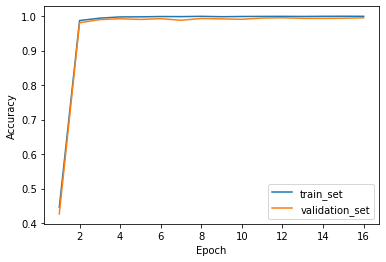

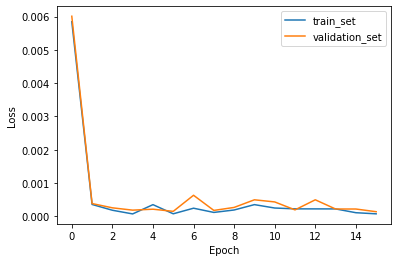

In [34]:
n = len(results['train_acc'])
X = np.linspace(1, n, n)

plt.plot(X,results['train_acc'][0:], label='train_set')
plt.plot(X,results['val_acc'][0:],label = 'validation_set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(results['train_loss'][0:], label = 'train_set')
plt.plot(results['val_loss'][0:], label = 'validation_set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

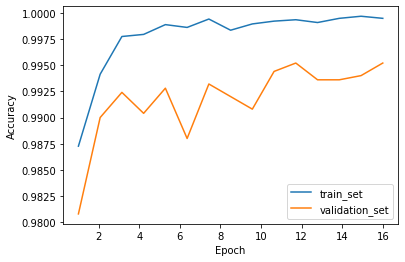

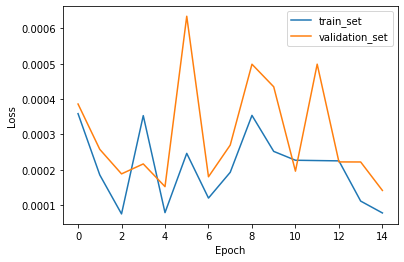

In [37]:
n = len(results['train_acc'])
X = np.linspace(1, n, n-1)

plt.plot(X,results['train_acc'][1:], label='train_set')
plt.plot(X,results['val_acc'][1:],label = 'validation_set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(results['train_loss'][1:], label = 'train_set')
plt.plot(results['val_loss'][1:], label = 'validation_set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Submission

In [27]:
test_csv_path = "../input/aerial-cactus-identification/sample_submission.csv"
test_path = "./test"
test_set = CactusDataset(test_csv_path, test_path, transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

def submission(net):
    net.eval()
    
    predictions = []
    for data in notebook.tqdm(test_loader):
        
        images, labels = data
        labels = labels.type(torch.FloatTensor)
        if use_cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.FloatTensor)            
        
        outputs = torch.squeeze(net(images))
        #print(outputs)
        pred = outputs.data
        
        predictions.append(int(pred))
  
    return predictions



In [ ]:

predictions = []
for i, data in enumerate(train_loader):
    inputs, labels = data
    break
    
labels = labels.type(torch.FloatTensor)
if use_cuda:
        images = images.type(torch.cuda.FloatTensor)            
        labels = labels.type(torch.cuda.FloatTensor)            
        
outputs = torch.squeeze(net(images))
pred = outputs.data.data
      


In [ ]:
sub = pd.read_csv(test_csv_path)
sub.head()
sub['has_cactus']= submission(net)


In [ ]:
sub.to_csv('submission.csv', index= False)
sub.head()

In [ ]:
#deleting the files containing the images to allow submission
import shutil

try:
    shutil.rmtree("./--")
except OSError as e:
    print("-- file already erased")
try:
    shutil.rmtree("./test")
except OSError as e:
    print("Test files already erased")
try:
    shutil.rmtree("./train")
except OSError as e:
    print("Training files already erased")